<a href="https://colab.research.google.com/github/gf4417/dl-cw3/blob/main/Coursework_3_Full_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework 3: RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook with your answers. Write your answers in the cells below for each question.


## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the RNN tutorial: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding
In this part you will have to:

- Implement an LSTM
- Implement a GRU

### Part 2 - Theory

Here you will answer some theoretical questions about RNNs -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

In [11]:
!wget http://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip


--2021-03-04 12:46:35--  http://www.doc.ic.ac.uk/~pam213/co460_files/data_speech_commands_v0.02.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245500277 (234M) [application/zip]
Saving to: ‘data_speech_commands_v0.02.zip’

data_speech_command 100%[===================>] 234.13M  1.11MB/s    in 3m 18s  

2021-03-04 12:49:53 (1.18 MB/s) - ‘data_speech_commands_v0.02.zip’ saved [245500277/245500277]



In [12]:
!mkdir data
!mkdir data/data_speech_commands_v0.02
!unzip data_speech_commands_v0.02.zip -d /content/data/data_speech_commands_v0.02/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data_speech_commands_v0.02/three/b76f6088_nohash_1.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b76f6088_nohash_2.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b76f6088_nohash_3.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7a0754f_nohash_0.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7a0754f_nohash_1.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7a0754f_nohash_2.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7a0754f_nohash_3.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7a6f709_nohash_0.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7a6f709_nohash_1.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b7e9f841_nohash_0.wav  
  inflating: /content/data/data_speech_commands_v0.02/three/b80d6c5e_nohash_0.wav  
  inflating: /content/dat

In [13]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "./data/" # this should change depending on where you have stored the data files

### Initial code before coursework questions start:

In [14]:
import math
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [15]:
def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [16]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)

        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [17]:

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Question 1:  Finalise the LSTM and GRU cells by completing the missing code

You are allowed to use nn.Linear.

In [18]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE - Question 1a) Complete the missing code
        ########################################################################

        self.x2h = nn.Linear(input_size, hidden_size * 4, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        # We used hx to pack both the hidden and cell states
        hx, cx = hx
        
        ########################################################################
        ## START OF YOUR CODE - Question 1b) Complete the missing code
        ########################################################################
        combined_input = self.x2h(input) + self.h2h(hx)

        forget, input, tanh, final = combined_input.chunk(4, 1)

        # Forget gate layer
        forget = torch.sigmoid(forget) # (forget) # (combined_input)
        # Input gate layer
        input = torch.sigmoid(input) # (input) #(combined_input)
        # Tanh layer
        tanh = torch.tanh(tanh) # (tanh) #(combined_input)
        # determining cy
        cy = forget * cx + input * tanh
        # Sigmoid 
        final = torch.sigmoid(final) # (final) #(combined_input)
        # Output
        hy = final * torch.tanh(cy)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        #activation = getattr(nn.functional, self.nonlinearity)                
        activation = getattr(torch, self.nonlinearity)
        hy = activation(self.x2h(input) + self.h2h(hx))

        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE - Question 1c) Complete the missing code
        ########################################################################
        self.x2h = nn.Linear(input_size, hidden_size*2, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size*2, bias=bias)

        self.x2r = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2r = nn.Linear(hidden_size, hidden_size, bias=bias)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE - Question 1d) Complete the missing code
        ########################################################################
        combined_input = self.x2h(input) + self.h2h(hx)

        reset, update = combined_input.chunk(2, 1)

        # Reset gate
        reset = torch.sigmoid(reset) #(combined_input)
        # Update gate
        update = torch.sigmoid(update) #(combined_input)
        # Final gate
        final = torch.tanh(self.x2r(input) + self.h2r(reset * hx))
        final = update * final
        # Output
        hy = hx * (1 - update)
        hy = hy + final 
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

### Question 2:  Finalise the RNNModel and BidirRecurrentModel

In [19]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE - Question 2a) Complete the missing code
        #
        #  Append the appropriate LSTM cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          for l in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias))
                
        ########################################################################
        ## END OF YOUR CODE
        ######################################################################## 

        elif mode == 'GRU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2b) Complete the missing code
        #
        #  Append the appropriate GRU cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(GRUCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          for l in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################        
        
        elif mode == 'RNN_TANH':
            
                    
        ########################################################################
        ## START OF YOUR CODE - Question 2c) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
          for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


                
        elif mode == 'RNN_RELU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2d) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
          for l in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "relu"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        else:
            raise ValueError("Invalid RNN mode selected.")

        # TODO: What is the purpose of this #
        self.att_fc = nn.Linear(self.hidden_size, 1)
        #####################################

        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):

        outs = []
        h0 = [None] * self.num_layers if hx is None else list(hx)
        
        # In this forward pass we want to create our RNN from the rnn cells,
        # ..taking the hidden states from the final RNN layer and passing these 
        # ..through our fully connected layer (fc).
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE - Question 2e) Complete the missing code
        #
        #  HINT: You may need a special case for LSTMs
        ########################################################################
        X = list(input.permute(1, 0, 2))
        # for j, l in enumerate(self.rnn_cell_list):
        #     hx_minus_one = h0[j]
        #     for i in range(input.shape[1]):
        #       hx = l(X[i], hx_minus_one)
        #       hx_minus_one = hx
        #       X[i] = hx

        if self.mode == 'LSTM':
          for j, l in enumerate(self.rnn_cell_list):
            if h0[j] is not None:
              hx_minus_one = (h0[j], h0[j])
            else: 
              hx_minus_one = h0[j]
            for i in range(input.shape[1]):
              hx = l(X[i], hx_minus_one)
              hx_minus_one = hx
              X[i] = hx[0]
          outs = X
        else:
          for j, l in enumerate(self.rnn_cell_list):
            hx_minus_one = h0[j]
            for i in range(input.shape[1]):
              hx = l(X[i], hx_minus_one)
              hx_minus_one = hx
              X[i] = hx
          outs = X

        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()

        out = self.fc(out)
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list_rev = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE - Question 2f) Complete the missing code
        #
        #  Create code for the following 'mode' values:
        # 'LSTM', 'GRU', 'RNN_TANH' and 'RNN_RELU'
        ########################################################################
        if mode == 'LSTM':
          # Forward
          self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          # Reverse
          self.rnn_cell_list_rev.append(LSTMCell(self.input_size,
                                                       self.hidden_size,
                                                       self.bias))
          for l in range(1, self.num_layers):
                # Forward
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias))
                # Reverse
                self.self.rnn_cell_list_rev.append(LSTMCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias))
        elif mode == 'GRU':
          # Forward
          self.rnn_cell_list.append(GRUCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias))
          # Reverse
          self.rnn_cell_list_rev.append(GRUCell(self.input_size,
                                                       self.hidden_size,
                                                       self.bias))
          for l in range(1, self.num_layers):
                # Forward
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias))
                # Reverse
                self.self.rnn_cell_list_rev.append(GRUCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias))     
        
        elif mode == 'RNN_TANH':
          # Forward
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
          # Reverse
          self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
          for l in range(1, self.num_layers):
                # Forward
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))
                # Reverse
                self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh")) 
        elif mode == 'RNN_RELU':
          # Forward
          self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
          # Reverse
          self.rnn_cell_list_rev.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
          for l in range(1, self.num_layers):
                # Forward
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "relu"))
                # Reverse
                self.rnn_cell_list_rev.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "relu")) 
        else:
            raise ValueError("Invalid RNN mode selected.")
          
        self.fc = nn.Linear(self.hidden_size*2, self.output_size)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        
        # In this forward pass we want to create our Bidirectional RNN from the rnn cells,
        # .. taking the hidden states from the final RNN layer with their reversed counterparts
        # .. before concatening these and running them through the fully connected layer (fc)
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE  - Question 2g) Complete the missing code
        ########################################################################
        ## !!! Implemented Type 2 - from piazza !!!
        ########################################################################
        outs = []
        outs_rev = []
        (h0, h0_rev) = ([None] * (self.num_layers), [None] * (self.num_layers)) if hx is None else list(hx)
        
        if self.mode == 'LSTM':
          X = list(input.permute(1, 0, 2))
          X_rev = list(reversed(input.permute(1, 0, 2)))
          for j, (l, l_rev) in enumerate(zip(self.rnn_cell_list, self.rnn_cell_list_rev)):
            if h0[j] is not None:
              hx_minus_one = (h0[j], h0[j]) 
            else:
              hx_minus_one = h0[j]
            for i in range(input.shape[1]):
              hx = l(X[i], hx_minus_one)
              hx_minus_one = hx
              X[i] = hx[0]
            if h0_rev[j] is not None:
              hx_minus_one_rev = (h0_rev[j], h0_rev[j])
            else:
              hx_minus_one_rev = h0_rev[j]
            for i in range(input.shape[1]-1, -1, -1):
              hx_rev = l_rev(X_rev[i], hx_minus_one_rev)
              hx_minus_one_rev = hx_rev
              X_rev[i] = hx_rev[0]   
          outs = X
          outs_rev = X_rev
        else:
          X = list(input.permute(1, 0, 2))
          X_rev = list(reversed(input.permute(1, 0, 2)))
          for j, (l, l_rev) in enumerate(zip(self.rnn_cell_list, self.rnn_cell_list_rev)):
            hx_minus_one = h0[j]
            for i in range(input.shape[1]):
              hx = l(X[i], hx_minus_one)
              hx_minus_one = hx
              X[i] = hx

            hx_minus_one_rev = h0_rev[j]
            for i in range(input.shape[1]-1, -1, -1):
              hx_rev = l_rev(X_rev[i], hx_minus_one_rev)
              hx_minus_one_rev = hx_rev
              X_rev[i] = hx_rev
          outs = X
          outs_rev = X_rev


        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)

        out = self.fc(out)
        return out

The code below trains a network based on your code above. This should work without error:

In [20]:

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

hidden_dim = 32
layer_dim = 1
bias = True

### Change the code below to try running different models:
#model = RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = RNNModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim)

#model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)
model = BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = BidirRecurrentModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim)
#model = BidirRecurrentModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim)


if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()

        outputs = model(audio)
        
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct // total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct // total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



Iteration: 20. Loss: 1.0276293754577637. V-Accuracy: 51  T-Accuracy: 50
Iteration: 40. Loss: 0.8063260912895203. V-Accuracy: 61  T-Accuracy: 59


KeyboardInterrupt: ignored

In [28]:
seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

hidden_dim = 32
layer_dim = 1
bias = True

models = [
  RNNModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim),
  RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim),
  RNNModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim),
  RNNModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim),
  BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim),
  BidirRecurrentModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim),
  BidirRecurrentModel("RNN_TANH", input_dim, hidden_dim, layer_dim, bias, output_dim),
  BidirRecurrentModel("RNN_RELU", input_dim, hidden_dim, layer_dim, bias, output_dim),
]

for i, model in enumerate(models):
  print(i, model)
  if torch.cuda.is_available():
      model.cuda()
      
  criterion = nn.CrossEntropyLoss()

  learning_rate = 0.01
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  loss_list = []
  iter = 0
  max_v_accuracy = 0
  reported_t_accuracy = 0
  max_t_accuracy = 0
  for epoch in range(num_epochs):
      for i, (audio, labels) in enumerate(train_loader):
          if torch.cuda.is_available():
              audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
              labels = Variable(labels.cuda())
          else:
              audio = Variable(audio.view(-1, seq_dim, input_dim))
              labels = Variable(labels)

          optimizer.zero_grad()

          outputs = model(audio)
          
          loss = criterion(outputs, labels)

          if torch.cuda.is_available():
              loss.cuda()

          loss.backward()

          optimizer.step()

          loss_list.append(loss.item())
          iter += 1

          if iter % valid_every_n_steps == 0:
              correct = 0
              total = 0
              for audio, labels in valid_loader:
                  if torch.cuda.is_available():
                      audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                  else:
                      audio = Variable(audio.view(-1, seq_dim, input_dim))

                  outputs = model(audio)

                  _, predicted = torch.max(outputs.data, 1)

                  total += labels.size(0)

                  if torch.cuda.is_available():
                      correct += (predicted.cpu() == labels.cpu()).sum()
                  else:
                      correct += (predicted == labels).sum()

              v_accuracy = 100 * correct // total
              
              is_best = False
              if v_accuracy >= max_v_accuracy:
                  max_v_accuracy = v_accuracy
                  is_best = True

              if is_best:
                  for audio, labels in test_loader:
                      if torch.cuda.is_available():
                          audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                      else:
                          audio = Variable(audio.view(-1, seq_dim, input_dim))

                      outputs = model(audio)

                      _, predicted = torch.max(outputs.data, 1)

                      total += labels.size(0)

                      if torch.cuda.is_available():
                          correct += (predicted.cpu() == labels.cpu()).sum()
                      else:
                          correct += (predicted == labels).sum()

                  t_accuracy = 100 * correct // total
                  reported_t_accuracy = t_accuracy

              print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



0 RNNModel(
  (rnn_cell_list): ModuleList(
    (0): LSTMCell(
      (x2h): Linear(in_features=20, out_features=128, bias=True)
      (h2h): Linear(in_features=32, out_features=128, bias=True)
    )
  )
  (att_fc): Linear(in_features=32, out_features=1, bias=True)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Iteration: 20. Loss: 1.0668549537658691. V-Accuracy: 44  T-Accuracy: 44
Iteration: 40. Loss: 1.0023609399795532. V-Accuracy: 56  T-Accuracy: 56
Iteration: 60. Loss: 0.9416700601577759. V-Accuracy: 60  T-Accuracy: 59
Iteration: 80. Loss: 0.8887938857078552. V-Accuracy: 59  T-Accuracy: 59
Iteration: 100. Loss: 0.8694924712181091. V-Accuracy: 59  T-Accuracy: 59
Iteration: 120. Loss: 0.8645832538604736. V-Accuracy: 59  T-Accuracy: 59
Iteration: 140. Loss: 0.8240135312080383. V-Accuracy: 60  T-Accuracy: 58
Iteration: 160. Loss: 0.861735999584198. V-Accuracy: 59  T-Accuracy: 58
Iteration: 180. Loss: 0.8127420544624329. V-Accuracy: 60  T-Accuracy: 60
Iteration: 200. Loss: 0.

## Part 2: Theoretical questions

#### Theory question 1: 
What is the _vanishing gradients problem_ and why does it occur? Which activation functions are more or less impacted by this, and why?

# **Answers**:
* **Your answer here describing vanishing gradients problem**

The vanishing gradient problem is a problem which effects gradient based learning methods, where parameters in the model are learnt by monitoring the effects of changing the parameters in minimal ways and evaluating its effect on the output of the model. Such small changes in parameters and their effects on the output can be expressed through gradients. The problem arises when the change to the output becomes so small that the correct parameters cannot be discovered and assigned - for network based models this will tend to occur for earlier layers especially when the models are deep. 

This tends to happen when activation functions are used which force outputs to exist within a small range, with most values being mapped to the extremes of the output space. Taking as an exaple the Sigmoid function at the extremes the function is very flat so large changes in value will result in small changes in output or in other words the gradient will be very small (and begins to vanish). This is exacerbated for a network with multiple layers.

Mathematically:

Taking the basic structure of an RNN the two main equations are:
$$h_t = \phi_h(W_hh_{t-1}+W_xx_t+b_h)$$
$$y_t=\phi_y(W_yh_t+b_y)$$

For Training the RNN a loss function is used and minimised:
$$L(\theta)=\sum_{t=1}^TL(y_t)$$

Finding the gradient with respect to $W_h$:
$$\nabla_{W_h}L(y_t) = \nabla L(y_t)\frac{dh_t}{dW_h}$$
$$\frac{dh_t}{dW_h} = \sum_{\tau=1}^{T}(\prod_{l=\tau}^{t-1}\frac{\delta h_{l+1}}{\delta h_l})\frac{\delta h_\tau}{\delta W_h}$$
$$\frac{\delta h_{l+1}}{\delta h_l} = [\phi_h(W_hh_{l}+W_xx_{l+1}+b_h), \phi_h(W_hh_{l}+W_xx_{l+1}+b_h), ...] \times W_h$$
$$\prod_{l=\tau}^{t-1} \frac{\delta h_{l+1}}{\delta h_l} = W_h^{t-\tau}$$

Therefore when $W_h$ is a matrix if the largest singular value is less than one the gradient will begin to vanish as $t - \tau$ increases (so when depth of network increases).

* **Two examples of activation functions more impacted by vanishing gradients**

1. Sigmoid 
2. Tanh

* **Two examples of activation functions less impacted by vanishing gradients, why are they impacted less?**

1. ReLU
2. PreLU

Both ReLU and PreLU avoid the vanishing gradient problem as their output values are not constrained within a small range and as the gradient is backpropaged through the layers the signal will not be degraded.


#### Theory question 2: 
Why do LSTMs help address the vanishing gradient problem compared to a vanilla RNN?

# **Answer:**

It should be noted that the LSTM implementation does not fix the vanishing gradient problem completely, instead evidense has shown it does mitigate its affects being able to learn longer dependencies compared to that of the RNN.

As explored above the main reason for the vanishing gradient problem is the recusive derivative of $\frac{\delta h_{l+1}}{\delta h_l}$. to mitigate this a separate cell state was included. The cell state ($C_t$) would be calculated from the previous cell state ($C_{t-1}$) with an update term weighted by the input gate value ($i\hat{C_t}$) and to stabilise this term from still growing uncontrollably a **forget gate** ($f$) was used to scale the previous input:
$$C_t = fC_{t-1} + i\hat{C_t}$$

The key equations for the LSTM:
$$f_t = \sigma ( W_f . [h_{t-1}, x_t] + b_f)$$
$$i_t = \sigma ( W_i . [h_{t-1}, x_t] + b_i)$$
$$o_t = \sigma ( W_o . [h_{t-1}, x_t] + b_o)$$
$$\hat c_t = \sigma ( W_c . [h_{t-1}, x_t] + b_c)$$
$$c_t = f_t \times c_{t-1} + i_t \times \hat c_t$$
$$h_t = o_t \times c_t$$

It was the presence of a recursive gradient that lead to the vanishing gradient problem. As in the previous question focusing on $\frac{\delta c_t}{\delta W_c}$, which requires thye computation of the following:
$$\prod_{l=\tau}^{t-1} \frac{\delta c_{l+1}}{\delta c_l} = \prod_{l=\tau}^{t-1}[f_{l+1} + o_l \times \frac{\delta c_{l+1}}{\delta h_l}]$$

Although this has no guarentee to not vanish, if $f_l \rightarrow 1$ for $l = \tau+1 ... i$ then $\prod_{l=\tau+1}^{i} f_l \times \frac{\delta c_\tau+1}{\delta h_\tau} \approx \frac{\delta c_\tau+1}{\delta h_\tau}$ which reduces the chance of previous information from vanishing at time $\tau$.

In a way where as with the RNN the term $\frac{\delta h_{l+1}}{\delta h_l}$ eventually takes values either greater than one ore in the range $[0,1]$ leading to vanishing or exploding gradients the term $\frac{\delta c_{l+1}}{\delta c_l} $ in the LSTM can take a value in either range for any given timestep. Therefore for an infinite number of steps there is no guarentee of dievergance or convergence. For example if convergence begins by setting the forget gate to have higher values the gradient will be prevented from vanishing as $\frac{\delta c_{l+1}}{\delta c_l} $ is brought closer to a value of 1.






#### Theory question 3: 

The plot below shows the training curves for three models A, B, and C, trained on the same dataset up to 100 epochs. The three models are a RNN, a LSTM and a GRU, not necessarily in that order.

* Which could plausibly be which? Why? Please explain your reasoning.

(In the cell below please set the values for A_model, B_model and C_model to be 'RNN', 'LSTM' or 'GRU'. This needs to be exact for the automatic marking.)

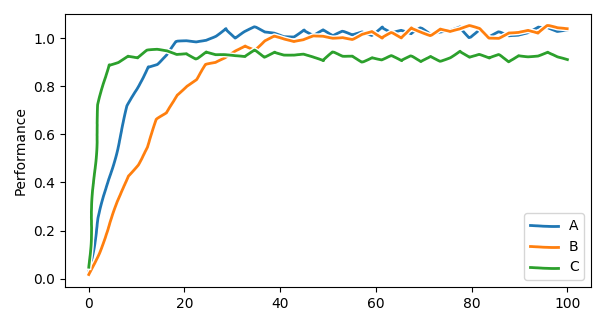

In [29]:
from IPython.display import Image, display
display(Image(filename='Performance by epoch.png', width=550))

In [ ]:
# Answers below:

A_model = 'GRU'
B_model = 'LSTM'
C_model = 'RNN'

# Give your reasons below:
# (C = RNN) : The RNN will perform worse due to its difficulty to train as a result of the vanishing gradient problem. Therefore C was best fit with worst performance.
# (A = GRU and B = LSTM) : From the literature it appears that GRU is easier to train than LSTM's due to its reduced complexity with fewer gates. Analysis from papers shows that GRU models tends to train quicker than LSTMS.

#### Theory question 4: 

When might you choose to use each of the three different types of models?

# **Your answers:**

All three types of models may be used for sequence prediction tasks. Some common applications for RNN's include:
1. Prediction problems
2. Machine translation
3. Video tagging
4. Text summarization
5. Music composition

* **Type of problem when best to use vanilla RNN:**

The main problem with basic vanilla RNN's is the challenge with training them due to the vanishing gradient problem. Therefore Vanilla RNN can be used when the sequence used for prediction is short (eg. for machine translation, a short phrase) - however in most cases it is just better to use GRU or LSTM's as they suffer less from vanishing gradients and so are more stable to train. However RNN's have the advantage of being faster to train and less computationally expensive. 

* **Type of problem to use GRU:**

Due to the two gates within the GRU cell the whole memory and hidden layers are used throught fixing the vanishing gradient problem. As a result the GRU cell is best used when the dataset for training is small. However in general due to the simpler nature of the GRU cell and its computational efficiency it should be the most popular choice for all tasks (like thoes mentioned above).

* **Type of problem to use LSTM:**

LSTM's have the additional complexity of the separate update and forget gates, this in part makes them better in theory at making more distant connections, however it also makes them harder to train. LSTM's should generally be used over basic RNN's however it is hard to argue that they are better than GRU. As a general rule of thumb it is preferred to use LSTM's when more data is available.
